# Is it a really game day without College GameDay?

A Data Analytics Programming Project

By: Shan Ali, Callie Gilmore, Jocelyne Walker

## Setup

In [63]:
# import libraries
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

from datetime import datetime
import re

# Special packages
import statsmodels.api as sm
from patsy import dmatrices

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


C:\Users\jocel\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ylabel', 'datetime', 'title', 'xlabel']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [25]:
# read data
cfb = pd.read_csv('CFBeattendance.csv', encoding= 'unicode_escape').dropna()

## Data Wrangling

**Clean Opponent**

In [26]:
# clean opponent column, ex.'No. 25 Georgia'
def opp2conf(s):
    x = 0
    if len(s.rsplit('*')) is 2:
        x = 1
    return x

def opp_clean(s):
    x = re.findall(r'\w+',s.rstrip('*'))
    if x[0] == 'No':
        x = x[2:]
    return ' '.join(x)

cfb['conference_game'] = cfb['Opponent'].apply(opp2conf)
cfb['Opponent'] = cfb['Opponent'].apply(opp_clean)
#cfb.head()

**Clean Rank, TV, Opponent_Rank**

In [27]:
# clean Rank, TV, Opponent_Rank
def RankToInt(s):
    if 'NR' in s:
        return 99
    else:
        return int(s)

# set NR team to r = 99
cfb['Rank'] = cfb['Rank'].map(RankToInt)
cfb['Opponent_Rank'] = cfb['Opponent_Rank'].map(RankToInt)

m = cfb.TV.str[:] == 'Not on TV'
cfb.loc[~m,'TV'] = 1
cfb.loc[m,'TV'] = np.nan
#cfb.head()

In [45]:
def isRank(s):
    if s == 99:
        return 0
    else:
        return 1



cfb['isRanked'] = cfb['Rank'].map(isRank)
cfb['OppisRanked'] = cfb['Opponent_Rank'].map(isRank)

**Clean Result**

In [29]:
# clean result
# get win dummy
cfb['Win'] = 0
cfb.loc[cfb.Result.str[0] == 'W','Win'] = 1

# get scores
cfb['Team_Score'] = cfb['Result'].apply(lambda x: re.findall(r'\d+',x)[0])
cfb['Opp_Score'] = cfb['Result'].apply(lambda x: re.findall(r'\d+',x)[1])

# get OT
def get_OT(s):
    ot = 0
    x = re.findall(r'OT',s)
    if x != []:
        ot = 1
        x = re.findall(r'(\d+)OT',s)
        if x != []:
            ot = x[0]
    return ot

cfb['OT'] = cfb['Result'].apply(get_OT)

**Clean New Coach and Tailgating**

In [30]:
# clean New Coach and Tailgating
cfb['New Coach'] = pd.get_dummies(cfb['New Coach'])[1]
cfb['Tailgating'] = pd.get_dummies(cfb['Tailgating'])[1]

**Clean Site**

In [31]:
# clean Site
def site2special(s):
    z = 0
    x = re.findall(r'\((.*?)\)',s)
    if x != []:
        z = 1
    return z

def gameday(s):
    z = 0
    x = re.findall(r'\((.*?)\)',s)
    if x != [] and x[0] == 'College GameDay':
        z = 1
    return z

def clean_site(s):
    #split at city?
    x = re.sub(r'\((.*?)\)','',s)
    #x = re.findall(r'\w+', x)
    return x

cfb['Special'] = cfb['Site'].apply(site2special)
cfb['GD'] = cfb['Site'].apply(gameday)
cfb['Site'] = cfb['Site'].apply(clean_site)

**Clean DateTime Features**

In [32]:
# convert all date info to DateTime
cfb['DateTime'] = pd.to_datetime(cfb['Date'] + ' ' + cfb['Time'])


**Drop redundant Features**

In [33]:
# drop redundant features
dropCol = ['Date','Time','Result','Year','Month','Day']
cfb.drop(columns=dropCol,inplace=True)
cfb['Year'] = cfb['DateTime'].dt.year

**Split Site Column**

In [34]:
def split_site(s):
    split = s.split()
    return split[len(split)-1]
    
cfb['State'] = cfb['Site'].apply(split_site)

cfb.loc[cfb.State == "Oklahoma", "State"] = "OK"
cfb.loc[cfb.State == "Dieg", "State"] = "CA"
cfb.loc[cfb.State == "Georgia", "State"] = "GA"
cfb.loc[cfb.State == "Indiana", "State"] = "IN"
cfb.loc[cfb.State == "StadiumHonolulu", "State"] = "HI"
cfb.loc[cfb.State == "Diego", "State"] = "CA"
cfb.loc[cfb.State == "Kentucky", "State"] = "KY"
cfb.loc[cfb.State == "Colorado", "State"] = "CO"
cfb.loc[cfb.State == "Jersey", "State"] = "NJ"
cfb.loc[cfb.State == "Missouri", "State"] = "MO"
cfb.loc[cfb.State == "Texas", "State"] = "TX"
cfb.loc[cfb.State == "Indiana", "State"] = "IN"
cfb.loc[cfb.State == "Oregon", "State"] = "OR"
cfb.loc[cfb.State == "Ohio", "State"] = "OH"
cfb.loc[cfb.State == "Nebraska", "State"] = "NE"
cfb.loc[cfb.State == "Mississippi", "State"] = "MS"
cfb.loc[cfb.State == "Virginia", "State"] = "VA"
cfb.loc[cfb.State == "York", "State"] = "NY"
cfb.loc[cfb.State == "Carolina", "State"] = "SC"
cfb.loc[cfb.State == "StadiumAtlanta", "State"] = "GA"
cfb.loc[cfb.State == "Tennessee", "State"] = "TN"
cfb.loc[cfb.State == "Illinois", "State"] = "IL"
cfb.loc[cfb.State == "Kansas", "State"] = "KS"
cfb.loc[cfb.State == "Louisiana", "State"] = "LA"
cfb.loc[cfb.State == "Arizona", "State"] = "AZ"
cfb.loc[cfb.State == "Alabama", "State"] = "AL"
cfb.loc[cfb.State == "Utah", "State"] = "UT"
cfb = cfb[cfb.State != '-']

print(cfb['State'].value_counts())

#print(re.findall('[A-Z][^A-Z]*', 'War Memorial StadiumLittle Rock, AR'))

TX    464
CA    456
OH    374
FL    314
IN    310
IL    300
AL    246
KS    239
NY    226
AR    215
TN    205
MS    203
MA    200
LA    164
GA    164
VA    155
WV    152
SC    150
HI    132
NE    130
PA    130
MI    129
WI    127
AZ    125
IA    123
NJ    118
OR    116
OK    116
ID    115
MO    114
UT    112
WA    109
CO    108
NV     98
NM     96
NC     83
KY     52
Name: State, dtype: int64


In [35]:
states = {
        'AK': 'O',
        'AL': 'S',
        'AR': 'S',
        'AS': 'O',
        'AZ': 'W',
        'CA': 'W',
        'CO': 'W',
        'CT': 'N',
        'DC': 'N',
        'DE': 'N',
        'FL': 'S',
        'GA': 'S',
        'GU': 'O',
        'HI': 'O',
        'IA': 'M',
        'ID': 'W',
        'IL': 'M',
        'IN': 'M',
        'KS': 'M',
        'KY': 'S',
        'LA': 'S',
        'MA': 'N',
        'MD': 'N',
        'ME': 'N',
        'MI': 'W',
        'MN': 'M',
        'MO': 'M',
        'MP': 'O',
        'MS': 'S',
        'MT': 'W',
        'NA': 'O',
        'NC': 'S',
        'ND': 'M',
        'NE': 'W',
        'NH': 'N',
        'NJ': 'N',
        'NM': 'W',
        'NV': 'W',
        'NY': 'N',
        'OH': 'M',
        'OK': 'S',
        'OR': 'W',
        'PA': 'N',
        'PR': 'O',
        'RI': 'N',
        'SC': 'S',
        'SD': 'M',
        'TN': 'S',
        'TX': 'S',
        'UT': 'W',
        'VA': 'S',
        'VI': 'O',
        'VT': 'N',
        'WA': 'W',
        'WI': 'M',
        'WV': 'S',
        'WY': 'W'
}

def find_region(s):
    return states[s]

cfb['Region'] = cfb['State'].apply(find_region)


**Cleaned DataFrame**

In [136]:
cfb.columns
cfb['DateTime'].value_counts()

2013-09-07 18:00:00    12
2009-09-12 18:00:00    11
2010-09-04 18:00:00    11
2011-09-17 18:00:00    10
2012-09-15 18:00:00    10
                       ..
2004-11-06 18:00:00     1
2016-09-17 20:15:00     1
2008-09-20 20:15:00     1
2018-09-28 19:00:00     1
2003-11-08 19:45:00     1
Name: DateTime, Length: 3914, dtype: int64

# Below I am just messing around with some visualizations

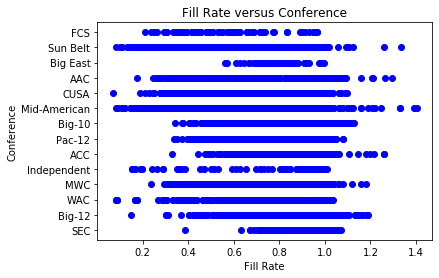

In [14]:
# Attendance by Conferece - Overall Not Super Helpful but can see SEC and Big 10 have highest peaks of attendance
plot(cfb['Fill Rate'], cfb['Conference'], marker='o', color='blue', linestyle='None')
xlabel('Fill Rate')
ylabel('Conference')
title('Fill Rate versus Conference')
show()

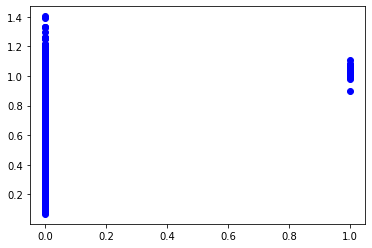

In [15]:
#Attendance vs GD - Not super telling although when GD is present, the lowest attendance is > 40,000
plot(cfb['GD'], cfb['Fill Rate'], marker='o', color='blue', linestyle='None')
xlabel='GD'
ylabel='Fill Rate'
title='Fill Rate versus GD'
show()

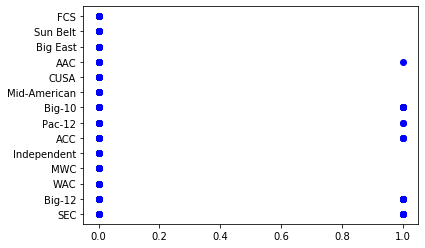

In [16]:
# GD vs Attendance - Not super helpful but shows there are only 6 conferences that have had GD
plot(cfb['GD'], cfb['Conference'], marker='o', color='blue', linestyle='None')
show()

In [17]:
# Next 2 plots im just messing around with grouping on conference but nothing super helpful
SEC = cfb[cfb['Conference'] == 'SEC']
Big12 = cfb[cfb['Conference'] == 'Big-12']
WAC = cfb[cfb['Conference'] == 'WAC']
MWC = cfb[cfb['Conference'] == 'MWC']
Ind = cfb[cfb['Conference'] == 'Independent']
ACC = cfb[cfb['Conference'] == 'ACC']
PAC12 = cfb[cfb['Conference'] == 'PAC-12']
Big10 = cfb[cfb['Conference'] == 'Big-10']
Mid = cfb[cfb['Conference'] == 'Mid-American']
CUSA = cfb[cfb['Conference'] == 'CUSA']
AAC = cfb[cfb['Conference'] == 'AAC']
BigEast = cfb[cfb['Conference'] == 'Big East']
SunBelt = cfb[cfb['Conference'] == 'Sun Belt']
FCS = cfb[cfb['Conference'] == 'FCS']

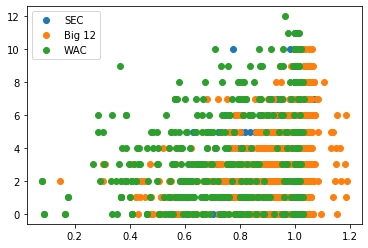

In [18]:
plot(SEC['Fill Rate'], SEC['Current Wins'], marker='o', linestyle='None', label='SEC')
plot(Big12['Fill Rate'], Big12['Current Wins'], marker='o', linestyle='None', label='Big 12')
plot(WAC['Fill Rate'], WAC['Current Wins'], marker='o', linestyle='None', label='WAC')
xlabel='Fill Rate'
ylabel='Current Wins'
legend(numpoints=1, loc='best')
show()

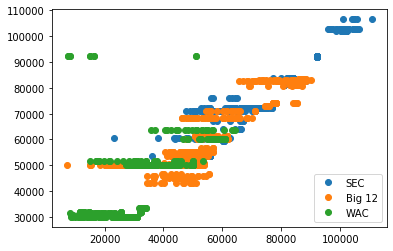

In [19]:
plot(SEC['Attendance'], SEC['Stadium Capacity'], marker='o', linestyle='None', label='SEC')
plot(Big12['Attendance'], Big12['Stadium Capacity'], marker='o', linestyle='None', label='Big 12')
plot(WAC['Attendance'], WAC['Stadium Capacity'], marker='o', linestyle='None', label='WAC')
legend(numpoints=1, loc='best')
show()

Text(0.5, 1.0, 'Top 10 Teams by Max Stadium Capacity')

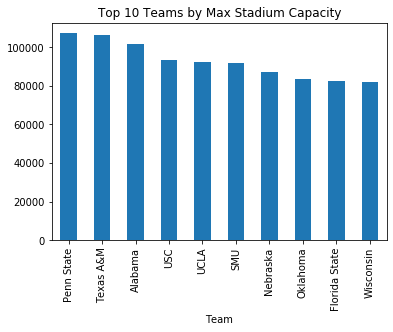

In [160]:
# Wins by Conference - shows which conferences have the most wins - could be kinda cool
#wins_conf = cfb.groupby(['Conference'])[['Win']].sum().sort_values(by='Win', ascending=False)
#wins_conf.plot(kind='bar')
#xlabel = 'Conference'


cfb.groupby('Team')['Stadium Capacity'].max().sort_values(ascending=False)[:10].plot(kind='bar')
plt.title('Top 10 Teams by Max Stadium Capacity')

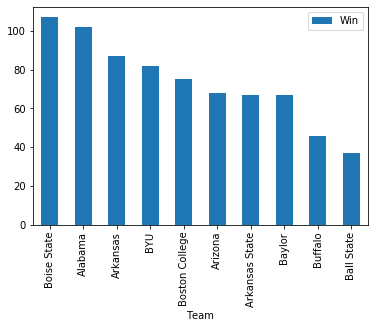

In [21]:
# Teams vs Wins - shows top 10 teams with the most wins - could be kinda cool
team_win = cfb.groupby(['Team'])[['Win']].sum().iloc[:10].sort_values(by='Win',ascending=False)
team_win.plot(kind='bar')

TypeError: 'str' object is not callable

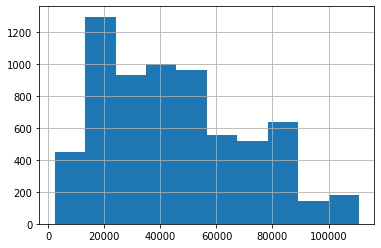

In [22]:
# frequency of attendance - most common is around 20,000 people - overall not super telling
cfb['Attendance'].hist()
xlabel('Attendance')
ylabel('Frequency')

In [ ]:
# Shows how the amounts of teams in each conference in our data set - could be kinda cool
conf_numb = cfb[['Team', 'Conference']].drop_duplicates(subset='Team')
conf_numb = conf_numb['Conference'].value_counts()
conf_numb

pie(conf_numb.values,
    labels=conf_numb.index.values,
    shadow=True)
axis('equal')

In [ ]:
pivoted = (pd.pivot_table(cfb, index = 'Team', \
                     columns = ['GD'], \
                     values = 'Fill Rate', \
                     fill_value = 0, \
                     aggfunc = 'mean').sort_values(by=1))

pivoted['GD Lift'] = 100*(pivoted[1] - pivoted[0])/pivoted[0]

print(pivoted.sort_values(by='GD Lift', ascending=False)[:20])

mask = pivoted['GD Lift'] > 0

print(pivoted[mask].sort_values(by='GD Lift')[:20])


In [ ]:
pivoted2 = (pd.pivot_table(cfb, index = ['Team'], \
                     values = ['Stadium Capacity','Fill Rate', 'GD'], \
                     fill_value = 0, \
                     aggfunc = {'Stadium Capacity':['min','max'],'Fill Rate':'mean', 'GD':'mean'}))

print(pivoted2.columns)

pivoted2['Capacity %Change'] = 100*(pivoted2['Stadium Capacity']['max'] - pivoted2['Stadium Capacity']['min'])/pivoted2['Stadium Capacity']['min']

print(pivoted2[pivoted2['GD']['mean']>0].sort_values(by=('GD','mean')))


In [ ]:
pivoted3 = pd.pivot_table(cfb, index = 'Year', \
                         values = ['Stadium Capacity', 'Fill Rate', 'Attendance'], \
                         aggfunc = 'mean')

#print(pivoted3)
#plot(pivoted3['Attendance'].rolling(2, min_periods=1).mean(), label = 'Attendance')
#plot(pivoted3['Fill Rate'].rolling(2, min_periods=1).mean(), label = 'Fill Rate')
#plot(pivoted3['Stadium Capacity'].rolling(2, min_periods=1).mean(), label = 'Stadium Capacity')
#legend(numpoints=1, loc='best')

fix,ax = plt.subplots()
ax.plot(pivoted3['Attendance'].rolling(2, min_periods=1).mean(), label = 'Attendance')
ax.plot(pivoted3['Stadium Capacity'].rolling(2, min_periods=1).mean(), label = 'Stadium Capacity', color = 'green')
ax.set_xlabel('Year', fontsize=14)
ax.set_ylim(40000,60000)
ax.set_xlim(2000,2018)
#ax.set_xticks(cfb['Year'].value_counts().index)
ax2=ax.twinx()
ax2.plot(pivoted3['Fill Rate'].rolling(2, min_periods=1).mean(), color='red', label = 'Fill Rate')
legend(numpoints=1,loc=0)
ax.legend(numpoints=1, loc='lower left')
plt.title('Attendance, Capacity, and Fill Rate Trends')

In [69]:
y, X = dmatrices('Q("Attendance") ~ Tailgating + isRanked + Conference + Q("Current Losses") \
                    + OppisRanked', data=cfb, return_type='dataframe')


model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("Attendance")   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     1542.
Date:                Sun, 09 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:24:30   Log-Likelihood:                -71730.
No. Observations:                6670   AIC:                         1.435e+05
Df Residuals:                    6652   BIC:                         1.436e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [37]:
y, X = dmatrices('Q("GD") ~ isRanked + I(Opponent_Rank + Rank) + Conference + Q("Current Wins") + Q("Current Losses") \
                    + conference_game + Year', data=cfb, return_type='dataframe')


model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Q("GD")   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     12.12
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           9.98e-36
Time:                        10:07:46   Log-Likelihood:                 8265.9
No. Observations:                6670   AIC:                        -1.649e+04
Df Residuals:                    6651   BIC:                        -1.636e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [149]:
from sklearn.metrics import mean_squared_error

cfb = cfb.sort_values(by='DateTime')

X = cfb[['Attendance','Tailgating', 'isRanked', 'Conference', 'Current Losses', 'OppisRanked']]
X = pd.get_dummies(data=X, drop_first=True)

train_set, test_set= np.split(X, [int(.83 *len(cfb))])

X_train = train_set[train_set.columns.difference(['Attendance'])]
y_train = train_set['Attendance']

X_test = test_set[test_set.columns.difference(['Attendance'])]
y_test = test_set['Attendance']

model = sm.OLS(y_train, X_train)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())
print(math.sqrt(result.mse_total))

pred=model.predict(result.params, X_train)

ypred=model.predict(result.params, X_test)

print(math.sqrt(mean_squared_error(y_train, pred)))
print(math.sqrt(mean_squared_error(y_test, ypred)))

print(cfb['Attendance'].std())
print(cfb['Attendance'].mean())

                                 OLS Regression Results                                
Dep. Variable:             Attendance   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                              5099.
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                        0.00
Time:                        18:13:57   Log-Likelihood:                         -60192.
No. Observations:                5536   AIC:                                  1.204e+05
Df Residuals:                    5519   BIC:                                  1.205e+05
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [132]:
cfb.to_csv('cfb.csv', index=False)

In [143]:
print(result.summary())


                                 OLS Regression Results                                
Dep. Variable:             Attendance   R-squared (uncentered):                   0.941
Model:                            OLS   Adj. R-squared (uncentered):              0.941
Method:                 Least Squares   F-statistic:                              4187.
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                        0.00
Time:                        16:19:29   Log-Likelihood:                         -48534.
No. Observations:                4468   AIC:                                  9.710e+04
Df Residuals:                    4451   BIC:                                  9.721e+04
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------